#### As of 12/6 to run this in JupyterLab do the following:
In the command line run: bash lab_extensions.sh


### Import things

In [1]:
import air as air
import ipywidgets as widgets
from ipywidgets import Layout
import matcher as match
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import scipy.stats as sc_stats
import warnings
import altair as alt
warnings.filterwarnings("ignore")
%load_ext autoreload

### Load in our data using existing functions

In [2]:
%autoreload
sensor_data = air.files_to_dataframe(glob.glob('../data/purple_air/*'))
matched_ses_data = match.station_matcher(sensor_data)

### Get mean AQI

In [5]:
%autoreload
matched_ses_data['mean_aqi'] = matched_ses_data.apply(lambda row: air.get_tract_mean_aqi(row), axis=1)
matched_ses_data['exposure_aqi100'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 100), axis=1)
matched_ses_data['exposure_aqi150'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 150), axis=1)
matched_ses_data['mean_aqi_no_smoke'] = matched_ses_data.apply(lambda row: air.get_tract_mean_aqi(row, include_smoke=False), axis=1)
matched_ses_data['exposure_aqi100_no_smoke'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 100, include_smoke=False), axis=1)
matched_ses_data['exposure_aqi150_no_smoke'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 150, include_smoke=False), axis=1)


## Now plot stuff!

Text(0.5, 1.0, 'Sensor counts by census tract')

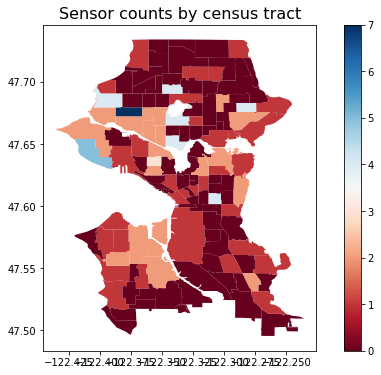

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='sensor_counts', cmap='RdBu', legend=True, ax=ax)
plt.title('Sensor counts by census tract', fontsize=16)

Text(0.5, 1.0, 'Exposure to AQI>=150 (no fires; min/day)')

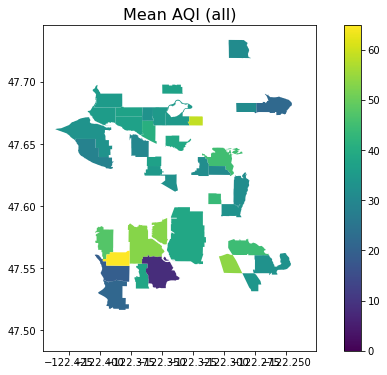

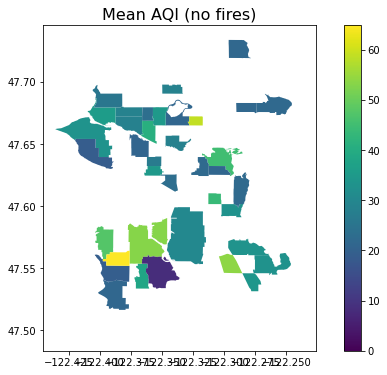

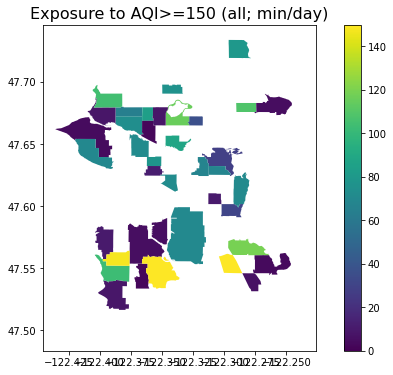

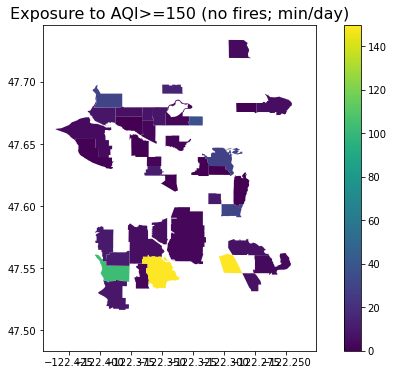

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='mean_aqi', legend=True, ax=ax, norm=colors.Normalize(0,65))
plt.title('Mean AQI (all)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='mean_aqi_ns', legend=True, ax=ax, norm=colors.Normalize(0,65))
plt.title('Mean AQI (no fires)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='exp150', legend=True, ax=ax, norm=colors.Normalize(0,150))
plt.title('Exposure to AQI>=150 (all; min/day)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='exp150_ns', legend=True, ax=ax, norm=colors.Normalize(0,150))
plt.title('Exposure to AQI>=150 (no fires; min/day)', fontsize=16)



### Some info on what different data exists in the SES dataset
All info is here: https://data-seattlecitygis.opendata.arcgis.com/datasets/racial-and-social-equity-composite-index <br>
Note: Maybe we should rename some of these! I also may be wrong on what some of these are <br>
RACE_ELL_O: Percentage of people of color <br>
SOCIOECONO: A composite of different socioeconomic things <br>
COMPOSITE_: The composite of everything <br>
HEALTH_PER: A composite index of different health metrics

### Scatter plot to see how the number of sensors in a plot relates to different SES metrics
Note: The size of each mark is scaled by the number of such census tracts. So for tracts with lots of sensors we might only have n=1

In [9]:
ses_metric_list = [
    'composite_percentile', 'socioeconomic_percentile',
    'health_percentile', 'race_english_origins_percentile',
    'percent_english)language_learners',
    'percent_income_below_200%_poverty_limit'
]

aqi_metric_list = [
    'mean_aqi',
    'exp100',
    'exp150',
    'mean_aqi_ns',
    'exp100_ns',
    'exp150_ns'
]

In [14]:
def sensor_count_plotting(ses_metric):
    
    # group by the number of sensors in the tract
    grouped = matched_ses_data.groupby('sensor_counts')
    
    # number of sensors in tract (x coordinate)
    num_sensors = np.array([name for name, group in grouped])
    
    # metric of interest (y coordinate)
    stat = np.array([group[ses_metric].mean() for name, group in grouped])
    
    # number of census tracts in the group
    tract_counts = np.array([group['OBJECTID'].count() for name, group in grouped])
    
    # regression
    slope, intercept, r_value, p_value, std_err = sc_stats.linregress(num_sensors, stat)
    
    #plot 
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(num_sensors, stat, s=tract_counts*10)
    ax.plot(num_sensors, num_sensors * slope + intercept, color='k')
    ax.text(x=0.7, y=0.9, s = 'r^2 value is: ' + str(round(r_value ** 2, 3)), fontsize=16,
             color='r', transform=ax.transAxes)
    plt.title(ses_metric + ' versus number of sensors by census tract', fontsize=18)
    plt.ylabel(ses_metric, fontsize=16)
    plt.xlabel('Sensors in census tract', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [15]:
def aqi_plotting(ses_metric, aqi_metric):
    
    # get AQI and SES data
    aqi = matched_ses_data[aqi_metric]
    counts = matched_ses_data[ses_metric]
    
    # regression (requires removal of NaN)
    mask = ~np.isnan(aqi) & ~np.isnan(counts)
    slope, intercept, r_value, p_value, std_err = sc_stats.linregress(aqi[mask], counts[mask])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(aqi, counts)
    
    aqi_space = np.linspace(np.amin(aqi), np.amax(aqi))
    ax.plot(aqi_space, aqi_space * slope + intercept, color='k')
    
    ax.text(x=0.7, y=0.9, s = 'r^2 value is: ' + str(round(r_value ** 2, 3)), fontsize=16,
             color='r', transform=ax.transAxes)
    plt.title(ses_metric + ' versus ' + aqi_metric, fontsize=16)
    plt.ylabel(ses_metric, fontsize=16)
    plt.xlabel(aqi_metric, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [16]:
widgets.interact(sensor_count_plotting,
                 ses_metric=widgets.Dropdown(
                     options=ses_metric_list,
                     description='Socioeconomic metric'))


interactive(children=(Dropdown(description='Socioeconomic metric', options=('composite_percentile', 'socioecon…

<function __main__.sensor_count_plotting(ses_metric)>

In [17]:
widgets.interact(aqi_plotting, 
                 ses_metric=widgets.Dropdown(
                     options=ses_metric_list,
                     description='Socioeconomic metric'),
                 aqi_metric = widgets.Dropdown(
                     options=aqi_metric_list,
                     description='Air Quality Metric'))

interactive(children=(Dropdown(description='Socioeconomic metric', options=('composite_percentile', 'socioecon…

<function __main__.aqi_plotting(ses_metric, aqi_metric)>

### Altair plots

In [12]:
data  = alt.InlineData(values = renamed_ses_data.__geo_interface__, #geopandas to geojson
                       # root object type is "FeatureCollection" but we need its features
                       format = alt.DataFormat(property='features',type='json')) 

def make_altair_chart(SES_metric):
    
    alt.renderers.enable('kaggle')
    
    chart = alt.Chart(data).mark_geoshape(
        stroke='black', strokeWidth=0.5
    ).encode(
        color = alt.Color('properties.%s' % SES_metric, type='quantitative', title='%s' % SES_metric),
        tooltip=[alt.Tooltip('properties.NAME10:N', title='Census Tract')]
    ).properties(
        width = 300,
        height = 500,
    )
    
    return chart

widgets.interact(make_altair_chart, SES_metric = sorted(renamed_ses_data.keys()))

interactive(children=(Dropdown(description='SES_metric', options=('ACRES_TOTA', 'COMPOSITE', 'COMPOSIT_1', 'GE…

<function __main__.make_altair_chart(SES_metric)>